# Predictive Brain Tumor Image AI Project - Preprocessing & Modeling

To make an image-processing brain tumor predictive model to automate on scale.

#################################################################

Brain MRI info
- Glioma: A type of cancer arising from glial cells in the brain or spinal cord.
- Meningioma: Usually a benign tumor from the meninges; rarely malignant.
- Notumor: Means no tumor was found.
- Pituitary: Refers to the gland; tumors (mostly benign) can form, rarely cancerous.

#################################################################

The Plan:
- the end goal is to make a model where you input image data of Brain MRI and will classify either Cancer or No Cancer.
- We will be experimenting with different data sets and different model methods.
 - Idea 1 is 4 classes (glioma, meningioma, notumor, pituitary), and have the model try to classify the 4 classes which will will then be organized into 2 classification (cancer or not).
    - The idea is that the model will place more effort in separating into 4 classification, which already has balanced data and thus be more accurate. And then we can add another layer to organized the results of 4 classifications into the 2 classifications of either cancer or no cancer.
 - Idea 2 is to have the Glioma class as cancer and the rest of the classes merged as not cancer. Then train the AI to classify between the 2 classes. But this will create a data imbalance issue that we will have to address.
- And each of those 2 ideas will have 2 data sets each as one is either using the non-augmented data (~6K image data so small and use pytorches random augmentation) or the augmented data (~ 87K image data)

#################################################################

The 2 Datasets:
|               | 4 classes          | 2 classes             |
|---------------|--------------------|-----------------------|
| Non-Augmented | Dataset 1          | Dataset 2             |

#################################################################

Cross validation:
- Will use k-fold and divide up each dataset into multiple folds to make it easier to cross validate.

#################################################################

Folder Structure:
- We will most likely be using pytorch and it's dataloader. That system likes to have the subfolders' names to apply labels to each of the images during training and testing.

#################################################################

Handle Data Split:
- We are going to be testing multiple different models and data sets and use cross-validation to decide which one is the best. Since we will be using cross-validation then that means we will be splitting up the data with k-folds. Since the current data is already split up into train and test pairs, then that means I have to merge the data together and then use code to split them up into folds.

#################################################################


# Initial Setup

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image as PILImage 
# using from PIL import Image as PILImage to count takes too long now as will try to also validate each image. We are assuming all the images are validated and are in correct format from Data Wrangling and EDA steps.

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from torch.utils.data import WeightedRandomSampler, DataLoader
from sklearn.utils import resample

import torch.nn as nn
import torch.nn.functional as F


from collections import Counter

In [4]:
# Caching the image data paths

image_dataset1_4_na_512_path = "./ImageData-Merge_Scaled_Cropped_Resize2"
image_dataset2_2_na__512_path = "./ImageData-Merge_Scaled_Cropped_Resize3"
image_dataset3_4_a_256_path = "./ImageData-Merge_Scaled_Cropped_Resize2_Augmented1"
image_dataset4_2_a_256_path = "./ImageData-Merge_Scaled_Cropped_Resize2_Augmented2"

In [5]:
# check if your GPU supports CUDA

if torch.cuda.is_available():
    print('cuda IS available')
else:
    print('cuda IS NOT available')


cuda IS available


In [6]:
# GPU is available, so we will use it for training the model.
device = 'cuda' 

# Data Imbalance

## Image Distribution

In [7]:
# Bar Graph Code
def quick_plot_bar_graph(categories, values, figsize = (10, 6), title='Image Counts with Percentages', xlabel='Brain Tumor Types', ylabel='Count'):
    """
    Plots a bar graph with counts and percentages displayed on top of the bars.

    Parameters:
    - categories: List of category names (x-axis).
    - values: List of corresponding values (heights of the bars).
    """
    # Calculate total for percentage calculation
    total = sum(values)
    
    # Plot the bar graph
    plt.figure(figsize=figsize)
    bars = plt.bar(categories, values, color='skyblue')

    # Add count and percentage on top of each bar
    for bar, value in zip(bars, values):
        height = bar.get_height()
        percentage = (value / total) * 100
        plt.text(bar.get_x() + bar.get_width() / 2, height, 
                 f'{value}\n({percentage:.1f}%)', 
                 ha='center', va='bottom', fontsize=10)

    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # Show the plot
    plt.show()

Glioma: 1619
Meningioma: 1634
NoTumor: 1726
Pituitary: 1740


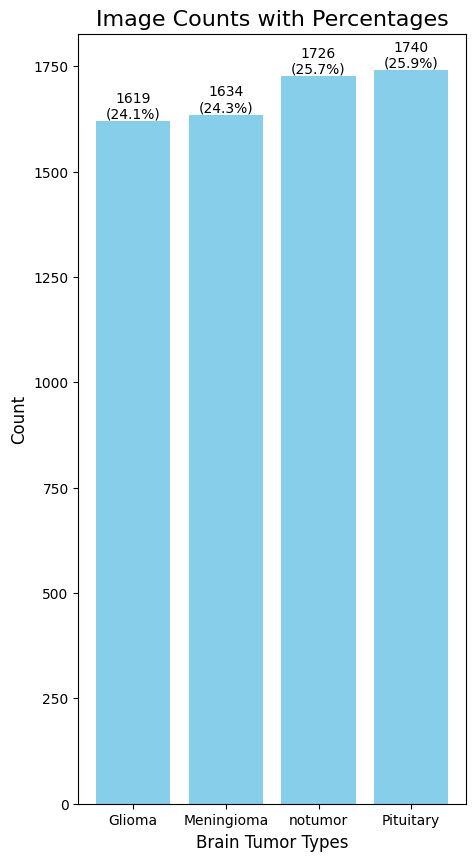

In [8]:
# Dataset 1 - 4 classes non augmented

# Load dataset
dataset = datasets.ImageFolder(root=image_dataset1_4_na_512_path)

# Get class distribution
class_counts = Counter(dataset.targets)

# Map indices to class names
class_names = dataset.classes

# Extract counts into variables
glioma_count_4_na = class_counts[dataset.class_to_idx['glioma']]
meningioma_count_4_na = class_counts[dataset.class_to_idx['meningioma']]
notumor_count_4_na = class_counts[dataset.class_to_idx['notumor']]
pituitary_count_4_na = class_counts[dataset.class_to_idx['pituitary']]

# Print counts
print(f"Glioma: {glioma_count_4_na}")
print(f"Meningioma: {meningioma_count_4_na}")
print(f"NoTumor: {notumor_count_4_na}")
print(f"Pituitary: {pituitary_count_4_na}")

quick_plot_bar_graph(['Glioma','Meningioma','notumor','Pituitary'], [glioma_count_4_na,meningioma_count_4_na,notumor_count_4_na,pituitary_count_4_na], figsize = (5, 10), title='Image Counts with Percentages', xlabel='Brain Tumor Types', ylabel='Count')

# There is not much data imbalance so it's good to go with this data set. 

Cancer: 1619
NonCancer: 5100


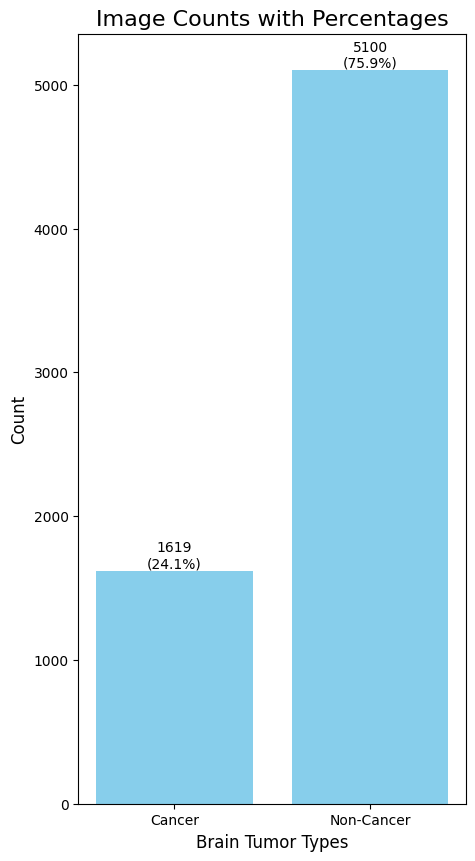

In [9]:
# Dataset 2 - 2 classes non augmented

# Load dataset
dataset = datasets.ImageFolder(root=image_dataset2_2_na__512_path)

# Get class distribution
class_counts = Counter(dataset.targets)

# Map indices to class names
class_names = dataset.classes

# Extract counts into variables
cancer_count_2_na = class_counts[dataset.class_to_idx['Cancer']]
noncancer_count_2_na = class_counts[dataset.class_to_idx['NonCancer']]

# Print counts
print(f"Cancer: {cancer_count_2_na}")
print(f"NonCancer: {noncancer_count_2_na}")


quick_plot_bar_graph(['Cancer', 'Non-Cancer'], [cancer_count_2_na, noncancer_count_2_na], figsize = (5, 10), title='Image Counts with Percentages', xlabel='Brain Tumor Types', ylabel='Count')

# there is a definite data imbalance with this


In [10]:
# Checking the data imbalance ratio

image_imbalance_ratio = noncancer_count_2_na / cancer_count_2_na

print(f"image imbalance ratio: {image_imbalance_ratio}")

# The dataset is approximately 3:1, meaning the cancer class is underrepresented.

image imbalance ratio: 3.1500926497838173


# How many splits for Cross Validation

In [11]:
total_nonaugmented_images = noncancer_count_2_na + cancer_count_2_na

print(f'Total number of images in non augmented sample: {total_nonaugmented_images}')

Total number of images in non augmented sample: 6719


In [12]:
def amount_each_fold(folds = 5):
    print (f'number of folds: {folds}')
    nonaugmented_images_each_folds = total_nonaugmented_images / folds

    print(f'non augmented sample each fold: {nonaugmented_images_each_folds}')
    print()

In [13]:
amount_each_fold(5)

amount_each_fold(10)

amount_each_fold(3)


number of folds: 5
non augmented sample each fold: 1343.8

number of folds: 10
non augmented sample each fold: 671.9

number of folds: 3
non augmented sample each fold: 2239.6666666666665



## Discovery

Looks like a good number of folds is 5. This also allows us to use the 80 20 rule when assembling them as well.

# Creating Dataloader & Folds

In [14]:
def get_transforms(augment=True, resize=(128, 128)):
    """
    Returns the transform pipeline for the dataset.

    Args:
        augment (bool): Whether to include augmentation transforms.
        resize (tuple): Target image size.

    Returns:
        transforms.Compose: Transformation pipeline.
    """
    if augment:
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Ensure images are single-channel as all MRI are grayscaled
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.Resize(resize),
            transforms.ToTensor(),
        ])
    else:
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Ensure images are single-channel as all MRI are grayscaled
            transforms.Resize(resize),
            transforms.ToTensor(),
        ])
    

def get_dataset(folder_path, transform):
    """
    Loads the dataset using torchvision.datasets.ImageFolder.

    Args:
        folder_path (str): Path to the dataset folder.
        transform (transforms.Compose): Transformations to apply.

    Returns:
        ImageFolder: The dataset object.
    """
    return datasets.ImageFolder(root=folder_path, transform=transform)


def calculate_class_weights(dataset):
    """
    Calculates class weights for handling class imbalance.

    Args:
        dataset (ImageFolder): The dataset object.

    Returns:
        torch.Tensor: Class weights.
    """
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1

    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
    return class_weights


def create_dataloader(dataset, class_weights, batch_size=32):
    """
    Creates a DataLoader with WeightedRandomSampler to handle class imbalance.

    Args:
        dataset (ImageFolder): The dataset object.
        class_weights (torch.Tensor): Class weights for imbalance handling.
        batch_size (int): Batch size for the DataLoader.

    Returns:
        DataLoader: A PyTorch DataLoader object.
    """
    sample_weights = [class_weights[label] for _, label in dataset]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return dataloader

def split_dataset(dataset, n_splits=5):
    """
    Splits the dataset into K folds for cross-validation.

    Args:
        dataset (ImageFolder): The dataset object.
        n_splits (int): Number of folds for cross-validation.

    Returns:
        list: A list of Subset objects, one for each fold.
    """
    dataset_size = len(dataset)
    fold_size = dataset_size // n_splits
    indices = torch.randperm(dataset_size).tolist()

    folds = [
        Subset(dataset, indices[i * fold_size:(i + 1) * fold_size])
        for i in range(n_splits)
    ]

    # Handle remainder if dataset size is not perfectly divisible
    remainder = dataset_size % n_splits
    if remainder > 0:
        for i in range(remainder):
            folds[i] = Subset(dataset, indices[i * fold_size:(i + 1) * fold_size + 1])

    return folds


def get_dataset_folds(folder_path, augment_data = True, resize=(128, 128), num_splits = 5):
    transform = get_transforms(augment=augment_data,resize=resize) # augment as the data is not augmented

    # Load the dataset
    dataset = get_dataset(folder_path, transform)

    # Calculate class weights
    class_weights = calculate_class_weights(dataset)

    # Split the dataset into folds
    folds = split_dataset(dataset, n_splits= num_splits)

    return dataset, class_weights, folds 

def get_all_fold_dataloaders(class_weights, folds, batch_size=32, shuffle=True):
    """
    Generates all possible training and validation DataLoader combinations for cross-validation.

    Args:
        class_weights (torch.Tensor): Class weights for WeightedRandomSampler.
        folds (list): List of dataset subsets, one for each fold.
        batch_size (int): Batch size for DataLoaders.
        shuffle (bool): Whether to shuffle validation DataLoader.

    Returns:
        list: A list of tuples, where each tuple contains (train_loader, val_loader).
    """
    dataloaders = []

    for i in range(len(folds)):
        # Use the ith fold for validation
        validation_fold = folds[i]
        # Use the remaining folds for training
        training_folds = [folds[j] for j in range(len(folds)) if j != i]

        # Combine training folds into a single dataset
        training_dataset = torch.utils.data.ConcatDataset(training_folds)

        # Create DataLoaders
        train_loader = create_dataloader(training_dataset, class_weights, batch_size=batch_size)
        val_loader = DataLoader(validation_fold, batch_size=batch_size, shuffle=shuffle)

        dataloaders.append((train_loader, val_loader))


    '''
    How to use this function: 

    # Get all dataloaders for cross-validation (e.g., for the first dataset)
    all_dataloaders1_4_na = get_all_fold_dataloaders(class_weights1_4_na, folds1_4_na, batch_size=batch_size, shuffle=shuffle)

    # Iterate through all combinations
    for fold_idx, (train_loader, val_loader) in enumerate(all_dataloaders1_4_na):
        print(f"Fold {fold_idx + 1}:")
        print(f"Training DataLoader: {len(train_loader)} batches")
        print(f"Validation DataLoader: {len(val_loader)} batches")
    '''
    
    return dataloaders


## Planning out the Batch size

In [14]:
print(total_nonaugmented_images)

6719


In [41]:
'''
Batch size math and making the model run faster:

To maximize the efficiency of the GPU, the batch size should be divisible by 8

Trial run:
a batch size of 32, 5 folds, and 6719 256x256 images
the model is running about 16 min
I check task manager and it shows that only ~8GB of vram is being used out of 24GB available, also my GPU only running at 30% efficiency. 
I want the model to run much faster with more data, so I can increase the batch size to 64 or 128.

Math:
512x512= 262,144 pixels per grayscale image, 1 grayscale pixel = 1 byte, so 262,144 bytes = 262.144 KB per grayscale image

non augmented images = 6719 images
augmented images = 87347 images

262.144 KB * 6719 =  1,761,354.816 KB = 1.761354816 GB is the total size of non augmented data
262.144 KB * 87347 =  22,897,491.968 KB = 22.897,491.968 GB is the total size of augmented data


Batches:
Batches mean how many images are loaded on the VRAM at the same time and processed at once. Batch size of 32 means 32 images are loaded at once and processed at once.
augmented data in total is 22 GB and my GPU has 24 GB of VRAM which is almost it's max, but it just means I don't really need to batch / load all of it in one run.

262.144 KB * 512 = 134,217.728 KB = 134.217728 MB
This is not including the model size and other things that are loaded in the VRAM

I feel like I can increase the batch size to 128 and still be able to run the model faster.

I made a dummy 512 x 512 data with a batch size of 512 and the GPU did not ran out of memories.
'''

'''
for the 6K data 
batch size 256 with 512 x 512 images took longer than 30 min to run for only 1 fold, 97% GPU utilization 
batch size 128 with 512 x 512 images took longer than 30 min to run for only 1 fold, 97% GPU utilization 
batch size 64 with 512 x 512 images took 3:50 min for 1 fold, 14 GB VRAM, 40% GPU utilization               * Chose this 

batch size 128 with 256 x 256 images took 6 min to run for 1 fold, and 10% gpu utilization
batch size 256 with 256 x 256 images took 3:50 min to run for 1 fold, and 16% gpu utilization 16Gb VRAM
batch size 384 with 256 x 256 images took longer than 6 min for 1 epoch, 99% gpu utilization
batch size 300 with 256 x 256 images took 5 min for 1 fold, 15% gpu utilization 17 GB VRAM
'''

'''
for the 87K data 
512x512 lag so much with 6K data we decide to lower the resolution of images to 256

batch size 128 with 256 x 256 images took 5 min for 1 epoch, or 50 min for 1 fold, and 20% gpu utilization  * Chose this 
batch size 256 with 256 x 256 images took 1 hour for 1 fold, that would take too long
'''

# It looks like playing GPU by power of 2 for this data is still more efficient for the GPU architecture and thus faster

## Defining the Dataloaders

In [ ]:
# apply to all the datasets
resize = (512, 512)
num_splits = 5
batch_size= 64
shuffle = True

In [17]:
# Dataloader 1 - 4 classes non augmented

dataset1_4_na_512, class_weights1_4_na_512, folds1_4_na_512 = get_dataset_folds(image_dataset1_4_na_512_path, augment_data = True, resize=resize, num_splits = num_splits) 
# augment as the data is not augmented

all_dataloaders1_4_na = get_all_fold_dataloaders(class_weights1_4_na_512, folds1_4_na_512, batch_size=batch_size, shuffle=shuffle)

In [18]:
# Dataloader 2 - 2 classes non augmented

dataset2_2_na, class_weights2_2_na_512, folds2_2_na_512 = get_dataset_folds(image_dataset2_2_na__512_path, augment_data = True, resize=resize, num_splits = num_splits) 
# augment as the data is not augmented

all_dataloaders2_2_na_512 = get_all_fold_dataloaders(class_weights2_2_na_512, folds2_2_na_512, batch_size=batch_size, shuffle=shuffle)

# Set Up Training and Validation Loop

In [21]:
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device='cuda'):
    """
    Train and validate the CNN model.

    Args:
        model (nn.Module): The CNN model.
        criterion (Loss): Loss function.
        optimizer (Optimizer): Optimizer.
        train_loader (DataLoader): Training DataLoader.
        val_loader (DataLoader): Validation DataLoader.
        num_epochs (int): Number of training epochs.
        device (str): Device to run the model on ('cuda' or 'cpu').

    Returns:
        nn.Module: Trained model.
    """
    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        print(f"Validation Loss: {val_loss / len(val_loader)}")
        print(classification_report(y_true, y_pred))

    return model


# Defining the CNN Model

In [22]:
'''

Convolution Layer Output Size Calculation:
output size = ((input_size - kernel_size + 2*padding) / stride) + 1

Pooling Layer Output Size Calculation:
output size = ((input_size - kernel_size) / stride) + 1


image sizes are all 512 x 512


Kernel size = 3x3, Stride = 1, Padding = 1
output size = ((512 - 3 + 2*1) / 1) + 1 = 512

Kernel size = 2x2, Stride = 2
output size = ((512 - 2) / 2) + 1 = 256

'''

'\n\nConvolution Layer Output Size Calculation:\noutput size = ((input_size - kernel_size + 2*padding) / stride) + 1\n\nPooling Layer Output Size Calculation:\noutput size = ((input_size - kernel_size) / stride) + 1\n\n\nimage sizes are all 512 x 512\n\n\nKernel size = 3x3, Stride = 1, Padding = 1\noutput size = ((512 - 3 + 2*1) / 1) + 1 = 512\n\nKernel size = 2x2, Stride = 2\noutput size = ((512 - 2) / 2) + 1 = 256\n\n'

In [56]:
# not used anymore as this model is too rigid for rapid experimenting.

# this class hard codes the model only for 512 x 512 images, so it's not very flexible, but it's a good starting point for a simple CNN model.

class SimpleCNN_512(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_512, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # in_channels=1 for grayscale images
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flattened size: 128 channels * 128 height * 64 width
        self.fc1 = nn.Linear(128 * 128 * 64, 128)  # HAVE TO CHANGE THIS IF IMAGE DIMENSION CHANGE
        self.fc2 = nn.Linear(128, num_classes) # num_classes = number of output classes

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Conv1 + ReLU
        x = self.pool(x)          # Pool1
        x = F.relu(self.conv2(x))  # Conv2 + ReLU
        x = self.pool(x)          # Pool2
        x = x.view(x.size(0), -1)  # Flatten feature map 
        x = F.relu(self.fc1(x))   # Fully connected layer 1
        x = self.fc2(x)           # Fully connected layer 2 (output)
        return x

# The `forward` method defines how the model processes input data and generates output.
# You do not call the `forward` method directly; instead, you call the model, which internally calls `forward`.

In [62]:
class FlexibleCNN(nn.Module):
    def __init__(self, num_classes):
        super(FlexibleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # in_channels=1 for grayscale images
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = None  # Placeholder; initialized later based on input size
        self.fc2 = nn.Linear(128, num_classes)  # Final layer depends only on num_classes

    def forward(self, x):
        # Pass through convolutional and pooling layers
        x = F.relu(self.conv1(x))  # Conv1 + ReLU
        x = self.pool(x)          # Pool1
        x = F.relu(self.conv2(x))  # Conv2 + ReLU
        x = self.pool(x)          # Pool2

        # Initialize fc1 dynamically based on the flattened size
        if self.fc1 is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(flattened_size, 128).to(x.device)

        x = x.view(x.size(0), -1)  # Flatten feature map
        x = F.relu(self.fc1(x))   # Fully connected layer 1
        x = self.fc2(x)           # Fully connected layer 2 (output)
        return x

## Testing the model if compatible with image dimensions

In [24]:
# Test using CPU

'''
# Dummy input with batch size of 512 and image size of 512x512
dummy_input = torch.randn(512, 1, 512, 512)

# Initialize the model
num_classes = 4  # Example number of classes
model = SimpleCNN(num_classes=num_classes)

# Test forward pass
output = model(dummy_input)
print(f"Output shape: {output.shape}")  # Should be [32, num_classes]
'''

'\n# Dummy input with batch size of 512 and image size of 512x512\ndummy_input = torch.randn(512, 1, 512, 512)\n\n# Initialize the model\nnum_classes = 4  # Example number of classes\nmodel = SimpleCNN(num_classes=num_classes)\n\n# Test forward pass\noutput = model(dummy_input)\nprint(f"Output shape: {output.shape}")  # Should be [32, num_classes]\n'

In [25]:
# Test using GPU with Dummy input with batch size of 32 and image size of 512x512
'''dummy_input = torch.randn(32, 1, 512, 512).cuda()  # Move input tensor to GPU

# Initialize the model
num_classes = 4  # Example number of classes
model = SimpleCNN(num_classes=num_classes).cuda()  # Move model to GPU

# Test forward pass
output = model(dummy_input)  # Forward pass on GPU
print(f"Output shape: {output.shape}")  # Should be [512, num_classes]

# finish the work really fast on GPU'''

'dummy_input = torch.randn(32, 1, 512, 512).cuda()  # Move input tensor to GPU\n\n# Initialize the model\nnum_classes = 4  # Example number of classes\nmodel = SimpleCNN(num_classes=num_classes).cuda()  # Move model to GPU\n\n# Test forward pass\noutput = model(dummy_input)  # Forward pass on GPU\nprint(f"Output shape: {output.shape}")  # Should be [512, num_classes]\n\n# finish the work really fast on GPU'

In [26]:
# Test using GPU with Dummy input with batch size of 512 and image size of 512x512
'''dummy_input = torch.randn(512, 1, 512, 512).cuda()  # Move input tensor to GPU

# Initialize the model
num_classes = 4  # Example number of classes
model = SimpleCNN(num_classes=num_classes).cuda()  # Move model to GPU

# Test forward pass
output = model(dummy_input)  # Forward pass on GPU
print(f"Output shape: {output.shape}")  # Should be [512, num_classes]'''

# GPU is 100% being utilized, unlike batch size of 32 and only 30% gpu utilization.

'dummy_input = torch.randn(512, 1, 512, 512).cuda()  # Move input tensor to GPU\n\n# Initialize the model\nnum_classes = 4  # Example number of classes\nmodel = SimpleCNN(num_classes=num_classes).cuda()  # Move model to GPU\n\n# Test forward pass\noutput = model(dummy_input)  # Forward pass on GPU\nprint(f"Output shape: {output.shape}")  # Should be [512, num_classes]'

# Train Model Trial Run

In [27]:
# Trial Run:
'''# Dataset1_4_na, batch size = 32, 5 folds, 6719 images, 256x256 images
# Take s 16 min, maybe I can try to improve the model speed by increasing the batch size to 512
# model overrides the previous fold model, so need to make a new code that will save each fold model


num_classes = len(dataset1_4_na.classes)  # Number of classes in the dataset

# Initialize the model, loss function, and optimizer
model = SimpleCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for fold_idx, (train_loader, val_loader) in enumerate(all_dataloaders1_4_na):
    print(f"Training Fold {fold_idx + 1}/{len(all_dataloaders1_4_na)}")
    model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device=device)'''


'# Dataset1_4_na, batch size = 32, 5 folds, 6719 images, 256x256 images\n# Take s 16 min, maybe I can try to improve the model speed by increasing the batch size to 512\n# model overrides the previous fold model, so need to make a new code that will save each fold model\n\n\nnum_classes = len(dataset1_4_na.classes)  # Number of classes in the dataset\n\n# Initialize the model, loss function, and optimizer\nmodel = SimpleCNN(num_classes=num_classes)\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\nfor fold_idx, (train_loader, val_loader) in enumerate(all_dataloaders1_4_na):\n    print(f"Training Fold {fold_idx + 1}/{len(all_dataloaders1_4_na)}")\n    model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device=device)'

In [28]:
'''
Output data is too long so will need to condense the most important info
Will focus on the validation loss. Accuracy is binary while loss is continuous and can be used to compare models.

Training Fold 1/5
Epoch 10/10, Training Loss: 0.0932158915758399
Validation Loss: 0.2437438233312042

Training Fold 2/5
Epoch 10/10, Training Loss: 0.06071736137632148
Validation Loss: 0.08299510001337954

Training Fold 3/5
Epoch 10/10, Training Loss: 0.011021780468711637
Validation Loss: 0.03882013740873108

Training Fold 4/5
Epoch 10/10, Training Loss: 0.017093674764315177
Validation Loss: 0.023375018104118118

Training Fold 5/5
Epoch 10/10, Training Loss: 0.013596458385834575
Validation Loss: 0.03204138073921231

'''

'\nOutput data is too long so will need to condense the most important info\nWill focus on the validation loss. Accuracy is binary while loss is continuous and can be used to compare models.\n\nTraining Fold 1/5\nEpoch 10/10, Training Loss: 0.0932158915758399\nValidation Loss: 0.2437438233312042\n\nTraining Fold 2/5\nEpoch 10/10, Training Loss: 0.06071736137632148\nValidation Loss: 0.08299510001337954\n\nTraining Fold 3/5\nEpoch 10/10, Training Loss: 0.011021780468711637\nValidation Loss: 0.03882013740873108\n\nTraining Fold 4/5\nEpoch 10/10, Training Loss: 0.017093674764315177\nValidation Loss: 0.023375018104118118\n\nTraining Fold 5/5\nEpoch 10/10, Training Loss: 0.013596458385834575\nValidation Loss: 0.03204138073921231\n\n'

In [29]:
print(f"avg validation loss: {(0.2437438233312042 + 0.08299510001337954 + 0.03882013740873108 + 0.03882013740873108 + 0.03204138073921231)/5}")

avg validation loss: 0.08728411578025165


# Train Model

## Define Function

In [64]:
def Train_Model_Cross_Validation(model, criterion, optimizer, lr, num_epochs, num_output_classes, device, model_name, dataloader ):
    # Adjust training loop
    for fold_idx, (train_loader, val_loader) in enumerate(dataloader):
        print(f"Training Fold {fold_idx + 1}/{len(dataloader)}")

        # Clear GPU memory before starting a new fold
        torch.cuda.empty_cache()

        # Reinitialize model and optimizer for each fold
        model = FlexibleCNN(num_classes=num_output_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model for this fold
        model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device)
        
        # Save the model for this fold with a unique filename
        torch.save(model.state_dict(), f"{model_name}_model_fold_{fold_idx + 1}.pth")
        print(f"{model_name} Model for fold {fold_idx + 1} saved as 'model_fold_{fold_idx + 1}.pth'")

## Hyperparameters

In [ ]:
lr = 0.001
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

## Perform K-Fold Cross Validation Training to see which model is best

In [ ]:
# dataset 1 - 4 classes non augmented

num_output_classes = len(dataset1_4_na_512.classes)
model = SimpleCNN_512(num_classes=num_output_classes).to(device)

Train_Model_Cross_Validation(
    model,
    criterion,
    optimizer, 
    lr, 
    num_epochs, 
    num_output_classes, 
    device, 
    'Data1_4_na_512', 
    all_dataloaders1_4_na)

In [ ]:
# dataset 2 - 2 classes non augmented

num_output_classes = len(dataset2_2_na.classes)
model = SimpleCNN_512(num_classes=num_output_classes).to(device)

Train_Model_Cross_Validation(
    model,
    criterion,
    optimizer, 
    lr, 
    num_epochs, 
    num_output_classes, 
    device, 
    'Data2_2_na_512', 
    all_dataloaders2_2_na_512)

## Which Model was the best

I will take all of the training loss, validation loss, and accuracy of the 2 models and aggregate them together using average.

In [2]:
import statistics

avg_m1_training_loss = statistics.mean(
    [0.0888093750524733, 
    0.0877730752164054, 
    0.116053645676445, 
    0.0748341116899003, 
    0.0975643898848266])

avg_m1_val_loss = statistics.mean(
    [0.23132011968465, 
    0.267330848390147, 
    0.200706772861026, 
    0.352789946255229, 
    0.207860841637565])

avg_m1_accuracy = statistics.mean(
    [0.93, 
    0.91, 
    0.93, 
    0.92, 
    0.92])

print(f'Model 1 Training Loss {avg_m1_training_loss}')
print(f'Model 1 Validation Loss {avg_m1_val_loss}')
print(f'Model 1 Accuracy {avg_m1_accuracy}')
print()

avg_m2_training_loss = statistics.mean(
    [0.0794861339076998, 
    0.0908131362160756, 
    0.0579512962694501, 
    0.062122426949264, 
    0.0730560059060475])

avg_m2_val_loss = statistics.mean(
    [0.119994813044156, 
    0.105766200859631, 
    0.142624080713306, 
    0.183626553575907, 
    0.126227928591626])

avg_m2_accuracy = statistics.mean(
    [0.93, 
    0.91, 
    0.93, 
    0.92, 
    0.92])

print(f'Model 2 Training Loss {avg_m1_training_loss}')
print(f'Model 2 Validation Loss {avg_m1_val_loss}')
print(f'Model 2 Accuracy {avg_m1_accuracy}')

Model 1 Training Loss 0.09300691950401012
Model 1 Validation Loss 0.2520017057657234
Model 1 Accuracy 0.922

Model 2 Training Loss 0.09300691950401012
Model 2 Validation Loss 0.2520017057657234
Model 2 Accuracy 0.922


## Discovery

It appears model 2 avg validation loss is the lowest, and just by looking at all the data across the board is the lowest.

Both models seems to have the training loss a bit lower than the validation loss across the board, This hints that slight overfitting happening. But in model 2, it seems this is not much of an issue.

Model 2's accuracy seems to be the highest.

It seems the overall best model method to going forth is model 2 with the idea of merging the data set together 

# Future Scope

- I will need to figure out a better way to organize and manipulate data while not using so many duplicate folders. 
- Our would like to experiment with augmenting the data (rot and flip). Upon experimenting, with this method we can increase the amount of data sets from 6K to 87K. 
- Need to find a way to run more than 10K of augmented data as currently it overloads my VRAM and trains for a long time, either optimized the file size, buy better hardware, or rent better or multiple hardware on the cloud.
- Experiment different types of CNN models structures than only the simple one. Chose small as dataset was small.
- One method is to optimize the parallel computing to process more data faster.